In [20]:
import os
import sys

from datetime import datetime

import math

import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from utils import NoamOptim

from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset

In [21]:
# data params
SEQ_LENGTH = 128
SEQ_FEATURES = 4
SEQ_OVERLAP = 16
    # when to discard a sequence that has to be padded, ratio of complete values compared to sequence length (0.6 = 60% full sequence)
DISCARD_SEQ_RATIO = 0.33
PAD_VALUE = -100

TEST_SPLIT = 0.1

# model params
EMBED_DIMS = 4
N_HEADS = 1
N_LAYERS = 4
    # feedforward neurons
FF_DIM = 48
EMBED_DROPOUT = 0.1
FF_DROPOUT = 0.1
ATTN_DROPOUT = 0.1
WEIGHT_DECAY = 0.01
LABEL_SMOOTHING = 0.05

BATCH_SIZE = 64
TRAIN_EPOCHS = 100000
LR = 1e-4
LR_WARMUP_RATIO = 0.1

RUN = "7"
RANDOM_STATE = np.random.randint(0, 100)

# # data params
# SEQ_LENGTH = 128
# SEQ_FEATURES = 4
# SEQ_OVERLAP = 16
#     # when to discard a sequence that has to be padded, ratio of complete values compared to sequence length (0.6 = 60% full sequence)
# DISCARD_SEQ_RATIO = 0.33
# PAD_VALUE = -100

# TEST_SPLIT = 0.1

# # model params
# EMBED_DIMS = 6
# N_HEADS = 1
# N_LAYERS = 6
#     # feedforward neurons
# FF_DIM = 32
# EMBED_DROPOUT = 0.1
# FF_DROPOUT = 0.3
# ATTN_DROPOUT = 0.1
# WEIGHT_DECAY = 0.03
# LABEL_SMOOTHING = 0.1

# BATCH_SIZE = 64
# TRAIN_EPOCHS = 100000
# LR = 1e-4
# LR_WARMUP_RATIO = 0.1

# RUN = "7"
# RANDOM_STATE = np.random.randint(0, 100)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA PREPROCESSING

In [23]:
# the fugue that we want to finish
# load data, 4 voices of instruments
target_data = np.loadtxt("data/contrapunctusXIV.txt")
print(target_data.shape)
print(target_data[0:10])

(3804, 4)
[[ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 49.]
 [ 0.  0.  0. 49.]]


In [24]:
# the data we have, which is other bach music, from other fugues
# load data
data = np.load('data/js-fakes-16thSeparated.npz', allow_pickle=True, encoding='latin1')
# we only use the note pitches
data = data["pitches"]

In [25]:
# change to list of dataframes
data = [pd.DataFrame(sequence, dtype = int) for sequence in data]
# append target important fugue we will predict on
data.append(pd.DataFrame(target_data).replace(0, -1))
data[0]

,0,1,2,3
0,67,63,58,51
1,67,63,58,51
2,67,63,58,51
3,67,63,58,51
4,68,63,60,48
...,...,...,...,...
123,63,58,55,39
124,63,58,55,39
125,63,58,55,39
126,63,58,55,39


## Examine raw data


unique values for each of the 4 voices:
[29, 35, 34, 36]


Text(0.5, 1.0, 'Sequence length')

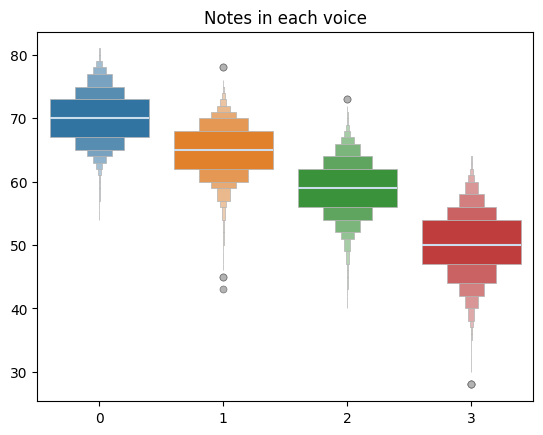

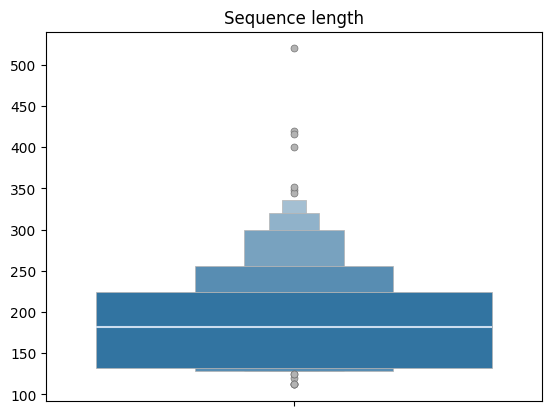

In [26]:
# check out data

# unique notes in each voice
print("unique values for each of the 4 voices:")
print([len(set(voice)) for voice in np.transpose(np.concatenate(data, axis = 0))])

# boxplot of notes
df = pd.concat(data)
sns.boxenplot(df.replace(-1, np.nan), linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Notes in each voice")

plt.figure()
# boxplot of lengths (we exclude the large (3800 length) fugue we want to finish and focus on the extra training data)
lengths = np.array([len(sequence) for sequence in data if len(sequence) < 3000])
sns.boxenplot(lengths,linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Sequence length")

## ~~Standardize Data~~ 

#### (NOT NEEDED FOR TRANSFORMER I FOUND OUT (INTS = TOKENS))


In [27]:
# standardization, while ignoring the -1's (silences, value does not matter directly)
#   first means and stds for each voice

# means = []
# stds = []

# for voice in concat_data:
#     values = concat_data[~np.isclose(concat_data[voice], -1.)][voice]
#     means.append(values.mean())
#     stds.append(values.std())
    
# print(means)
# print(stds)

# # now we standardize the values of data
# for i, df in enumerate(data):
#     for j, (mean, std) in enumerate(zip(means, stds)):
#         indices = ~np.isclose(data[i][j], -1.)
#         data[i].loc[indices, j] = (data[i].loc[indices, j] - mean) / std
        
#         # We change silences to 0. (mean) and add an boolean feature 
#         data[i].loc[~indices, j] = 0.
#         data[i][str(j) + "s"] = 0.
#         data[i].loc[~indices, str(j) + "s"] = 1.

In [28]:
# # check standardization
# sns.boxenplot(pd.concat(data).iloc[:,:4], linewidth=.5, linecolor=".7",
#               line_kws=dict(linewidth=1.5, color="#cde"),
#               flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Notes in each voice")

#### Instead, create mapping to more compact range for each voice


In [29]:
df = pd.concat(data).astype(int)
print(set(df[0]))

{54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, -1}


In [30]:
# start with inverse mapping
int_map_list_inv = []
int_map_list = []
for voice in range(df.shape[1]):
    int_map_list_inv.append(dict([(key + 1, value) for key, value in enumerate(np.sort(list(set(df[voice]))))]))
    # important, add padding key
    int_map_list_inv[-1][0] = PAD_VALUE
    int_map_list.append({value: key for key, value in int_map_list_inv[-1].items()})

for map, inv_map in zip(int_map_list, int_map_list_inv):
    print(dict(sorted(map.items())))
    print(dict(sorted(inv_map.items())))

{-100: 0, -1: 1, 54: 2, 55: 3, 56: 4, 57: 5, 58: 6, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29}
{0: -100, 1: -1, 2: 54, 3: 55, 4: 56, 5: 57, 6: 58, 7: 59, 8: 60, 9: 61, 10: 62, 11: 63, 12: 64, 13: 65, 14: 66, 15: 67, 16: 68, 17: 69, 18: 70, 19: 71, 20: 72, 21: 73, 22: 74, 23: 75, 24: 76, 25: 77, 26: 78, 27: 79, 28: 80, 29: 81}
{-100: 0, -1: 1, 43: 2, 45: 3, 46: 4, 47: 5, 48: 6, 49: 7, 50: 8, 51: 9, 52: 10, 53: 11, 54: 12, 55: 13, 56: 14, 57: 15, 58: 16, 59: 17, 60: 18, 61: 19, 62: 20, 63: 21, 64: 22, 65: 23, 66: 24, 67: 25, 68: 26, 69: 27, 70: 28, 71: 29, 72: 30, 73: 31, 74: 32, 75: 33, 76: 34, 78: 35}
{0: -100, 1: -1, 2: 43, 3: 45, 4: 46, 5: 47, 6: 48, 7: 49, 8: 50, 9: 51, 10: 52, 11: 53, 12: 54, 13: 55, 14: 56, 15: 57, 16: 58, 17: 59, 18: 60, 19: 61, 20: 62, 21: 63, 22: 64, 23: 65, 24: 66, 25: 67, 26: 68, 27: 69, 28: 70, 29: 71, 30: 72, 31: 73, 32: 

## Standardize Sequence / Input Length
Create subsequences of length *SEQ_LENGTH* with *SEQ_OVERLAP* timesteps overlap, discard sequences that do not fill the sequence in ratio of *DISCARD_SEQ_RATIO*.

In [31]:
# We want standard input sequence length
#   labels and input sequences get shifted by 1, therefore we need +1
temp_data = []
for sequence in data:
    for i in range(0, len(sequence), (SEQ_LENGTH + 1) - SEQ_OVERLAP):
        # subsequence fits entirely in the standard size
        if (i + (SEQ_LENGTH + 1)) < len(sequence):
            temp_data.append(pd.DataFrame(sequence[i:i+(SEQ_LENGTH + 1)].values))
        # padding needed, we discard if the remaining sequence does not fill some ratio of the standard sequence length
        elif len(sequence[i:]) > math.floor(SEQ_LENGTH * DISCARD_SEQ_RATIO):
            temp_data.append(pd.DataFrame(sequence[i:]).reset_index(drop = True).reindex(range((SEQ_LENGTH + 1)), fill_value = PAD_VALUE))
            
data = temp_data

### Now map data to lower range

In [32]:
for i, df in enumerate(data):
    data[i][0] = df[0].map(lambda x: int_map_list[0][x])
    data[i][1] = df[1].map(lambda x: int_map_list[1][x])
    data[i][2] = df[2].map(lambda x: int_map_list[2][x])
    data[i][3] = df[3].map(lambda x: int_map_list[3][x])

Unique values in voice 0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Unique values in voice 1 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Unique values in voice 2 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Unique values in voice 3 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
All 37 unique values in data [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Number of Sequences (was 500): 934


Text(0.5, 1.0, 'Distribution of notes from index 42 to the end of each sequence which is index 128 (0 is padding).')

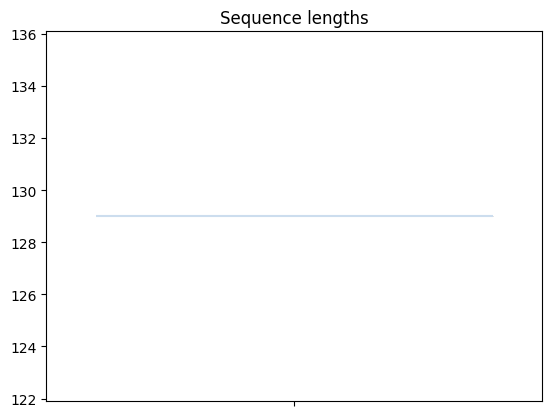

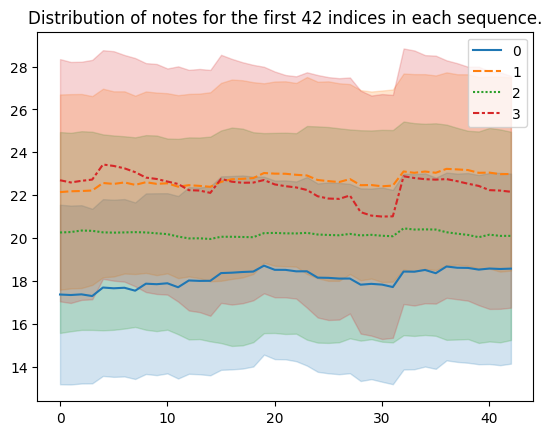

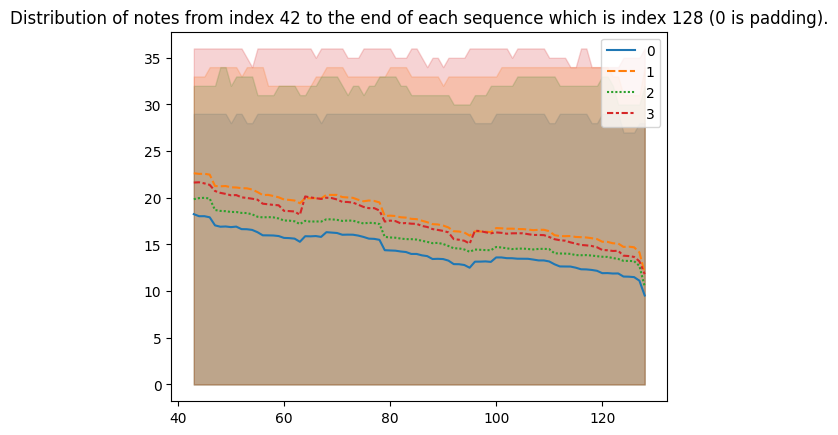

In [33]:
# concat df
# df = pd.concat(data).drop(['0s', '1s', '2s', '3s'], axis=1).dropna(axis=1) 
df = pd.concat(data)

# check high and low values
np.set_printoptions(suppress=True, precision = 3)
print("Unique values in voice 0", np.unique(df[0].values))
print("Unique values in voice 1", np.unique(df[1].values))
print("Unique values in voice 2", np.unique(df[2].values))
print("Unique values in voice 3", np.unique(df[3].values))

# needed later
all_uniques = np.unique(df.values)
n_uniques = len(all_uniques)

print("All {} unique values in data".format(n_uniques), all_uniques)

# check sequence lengths
sns.boxenplot([len(seq) for seq in data], linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Sequence lengths")
print("Number of Sequences (was 500):", len(data))
plt.figure()

# plot sequences
sns.lineplot(df.loc[df.index <= math.floor(SEQ_LENGTH * DISCARD_SEQ_RATIO)], errorbar = "sd").set_title("Distribution of notes for the first {} indices in each sequence.".format(math.floor(SEQ_LENGTH * DISCARD_SEQ_RATIO)))
plt.figure()
sns.lineplot(df.loc[df.index > math.floor(SEQ_LENGTH * DISCARD_SEQ_RATIO)], errorbar = ("pi", 100)).set_title("Distribution of notes from index {} to the end of each sequence which is index {} (0 is padding).".format(math.floor(SEQ_LENGTH * DISCARD_SEQ_RATIO), SEQ_LENGTH))


## Create Labels
Shift sequence one timestep to the right for labels.

In [34]:
# create labels by shifting one to the right
input_seqs = []
label_seqs = []
for sequence in data:
    input_seqs.append(sequence[:-1])
    label_seqs.append(sequence[1:])

input_seqs = np.array(input_seqs, dtype = np.int32)
label_seqs = np.array(label_seqs, dtype = np.int32)
print("Input sequences")
display(pd.DataFrame(input_seqs[3]))
print("Output sequences, shifted by one in temporal direction")
display(pd.DataFrame(label_seqs[3])) 

Input sequences


,0,1,2,3
0,28,30,26,25
1,28,32,26,25
2,28,32,26,25
3,27,33,19,27
4,27,33,19,27
...,...,...,...,...
123,0,0,0,0
124,0,0,0,0
125,0,0,0,0
126,0,0,0,0


Output sequences, shifted by one in temporal direction


,0,1,2,3
0,28,32,26,25
1,28,32,26,25
2,27,33,19,27
3,27,33,19,27
4,27,33,19,28
...,...,...,...,...
123,0,0,0,0
124,0,0,0,0
125,0,0,0,0
126,0,0,0,0


## Create Train Test Split

In [35]:
# create train test split
inputs_train, inputs_test, labels_train, labels_test = train_test_split(input_seqs, 
                                                                        label_seqs, 
                                                                        test_size = TEST_SPLIT, 
                                                                        random_state = RANDOM_STATE)
print("(nr_samples, seq_length, features)")
print("train sizes:", inputs_train.shape, labels_train.shape)
print("test sizes:", inputs_test.shape, labels_test.shape)

(nr_samples, seq_length, features)
train sizes: (840, 128, 4) (840, 128, 4)
test sizes: (94, 128, 4) (94, 128, 4)


# Dataloaders

In [36]:
train_dataset = TensorDataset(torch.tensor(inputs_train).long(), torch.tensor(labels_train).long())
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

eval_dataset = TensorDataset(torch.tensor(inputs_test).long(), torch.tensor(labels_test).long())
eval_loader = DataLoader(eval_dataset, batch_size = BATCH_SIZE, shuffle = True)

# Model initialization

In [37]:
from transformer import MultiVarTransformer

n_features = inputs_train.shape[2]

transformer = MultiVarTransformer(n_uniques, 
                                  n_features, 
                                  SEQ_LENGTH, 
                                  n_embed_dims = EMBED_DIMS, 
                                  n_heads = N_HEADS, 
                                  n_layers = N_LAYERS, 
                                  ff_dim = FF_DIM, 
                                  padding_token = int_map_list[0][PAD_VALUE],
                                  embed_dropout = EMBED_DROPOUT,
                                  attn_dropout = ATTN_DROPOUT,
                                  ff_dropout = FF_DROPOUT)
optimizer = NoamOptim(optim.AdamW(transformer.parameters(), lr = LR, weight_decay = WEIGHT_DECAY),
                      transformer.d_model, 2, 4000)

# ignore padding index of mapped padding value (same for all mapping functions)
loss_func = nn.CrossEntropyLoss(ignore_index = int_map_list[0][PAD_VALUE], label_smoothing = LABEL_SMOOTHING)
loss_func_eval = nn.CrossEntropyLoss(ignore_index = int_map_list[0][PAD_VALUE])

# Training loop

In [ ]:
tb_writer = SummaryWriter("runs/" + datetime.now().strftime("%d_%H_%M"))

transformer = transformer.to(device)

for epoch in range(TRAIN_EPOCHS):
    train_loss_sum = 0.
    eval_loss_sum = 0.
    best = float('inf')
    
    # training
    transformer.train()
    for src_batch, tgt_batch in train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        # zero grad
        optimizer.zero_grad()
        # forward
        output = transformer(src_batch, tgt_batch)
        # loss
        loss = loss_func(output, tgt_batch)
        # backward
        loss.backward()
        # grad step
        optimizer.step()
        
        # for logs
        train_loss_sum += loss.item()
    # avg train loss tensorboard
    tb_writer.add_scalar("train_loss", train_loss_sum / len(train_loader), epoch)
    
    # eval
    transformer.eval()
    with torch.no_grad():
        for src_batch, tgt_batch in eval_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            # forward
            output = transformer(src_batch, tgt_batch)
            # loss
            loss = loss_func_eval(output, tgt_batch)

            # for logs
            eval_loss_sum += loss
    # avg eval loss 
    avg_eval_loss = eval_loss_sum / len(eval_loader)
    if avg_eval_loss < best:
        best = avg_eval_loss
        torch.save({
                    "transformer": transformer.state_dict(),
                    "epoch": epoch,
                    "random_state": RANDOM_STATE,
                    } | optimizer.get_state_dict(), 
                   f = "models/best_eval_" + RUN + ".pt")
    # tensorboard
    tb_writer.add_scalar("eval_loss", avg_eval_loss, epoch)